In [1]:
import lecroy
import rigol
import numpy as np
from matplotlib import pyplot as plt
from sigproc_kit import *

LECROY,WR620ZI,LCRY2805N57162,8.5.1
Rigol Technologies,DG4202,DG4E212801262,00.01.14


In [2]:
##################################################
##              program RIGOL AWG               ##
##################################################


awg_samples = 2**12
awg_period = 250e-9
awg_time = np.linspace(0,awg_period,awg_samples)


test_curr = -2e-6
injection_resistor = 32.8e3
test_amp = test_curr*injection_resistor

y1 = 0 + test_amp*(awg_time>50e-9)*(awg_time<350e-9)
y2 = y1

rigol.set_waveform(1,awg_time,y1)
rigol.set_waveform(2,awg_time,y2)


In [9]:
##################################################
##           configure LeCroy Scope             ##
##################################################

lecroy.clear_all()
lecroy.set_tdiv(100e-9)

# access scope sources by labels
s = {
    "RIGOL_AWG_CH2"    :"C1", # set to 50R DC
    "PASTTREC_LVDS"    :"C4", # use LeCroy ZD1500 differential probe
    "PASTTREC_analog"  :"C3"  # set to 50R DC
}

# set vertical amplifications and offsets
lecroy.set_vdiv(              s["PASTTREC_LVDS"],200e-3)

lecroy.set_vdiv(              s["RIGOL_AWG_CH2"],50e-3)

lecroy.set_vdiv(              s["PASTTREC_analog"],100e-3 )
lecroy.set_voffset(           s["PASTTREC_analog"],-1000e-3 )


# access scope measurements by labels
m = {
    "PASTTREC_t1"  : "p3",
    "PASTTREC_tot" : "p4"
}

# TDC measurements for differential probe at 100R terminated PASTTREC LVDS output
lecroy.setup_measurement(m["PASTTREC_t1"] ,s["PASTTREC_LVDS"],"delay")
lecroy.setup_measurement(m["PASTTREC_tot"],s["PASTTREC_LVDS"],"widthn")


# access scope trigger channels by labels

t = {
    "RIGOL_AWG_SYNC1" : "D9",
    "RIGOL_AWG_SYNC2" : "D10"
}



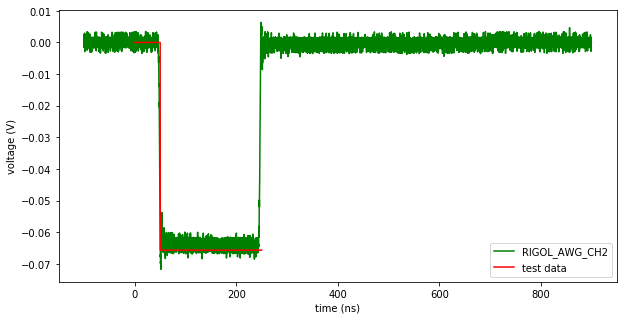

In [10]:
##################################################
##             measure AWG Waveform             ##
##################################################

lecroy.set_trig_source(t["RIGOL_AWG_SYNC2"])

time, wfm = lecroy.capture_waveforms([
    s["RIGOL_AWG_CH2"]
])

time_ns = time*1e9

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(time_ns,wfm[s["RIGOL_AWG_CH2"]] ,"g" ,label="RIGOL_AWG_CH2")
plt.plot(1e9*awg_time, y2 ,"r" ,label="test data")

plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
plt.show()

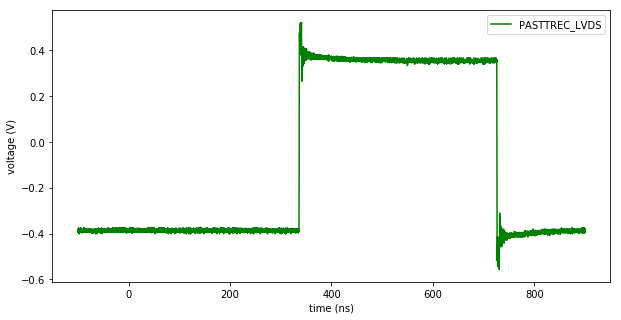

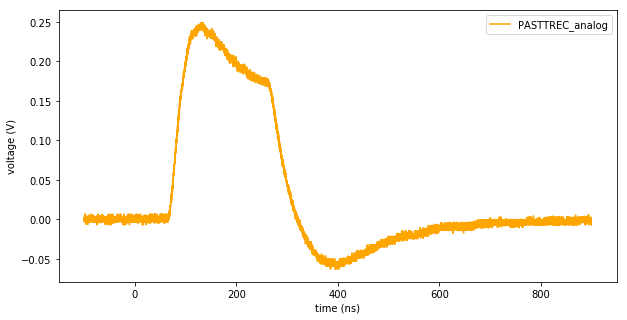

In [5]:
##################################################
##      capture ana waveform and LVDS out       ##
##################################################

lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])

plt.rcParams["figure.figsize"] = (10,5)

lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])

time, wfm = lecroy.capture_waveforms([
    s["PASTTREC_LVDS"],
    s["PASTTREC_analog"]
])

time_ns = time*1e9

# remove analog signal baseline, calculate bl from the first 10% of the sample
pt_ana = wfm[s["PASTTREC_analog"]]
pt_ana = remove_baseline(pt_ana,fraction=0.08)

plt.plot(time_ns,wfm[s["PASTTREC_LVDS"]] ,"g" ,label="PASTTREC_LVDS")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
plt.show()

plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
plt.show()

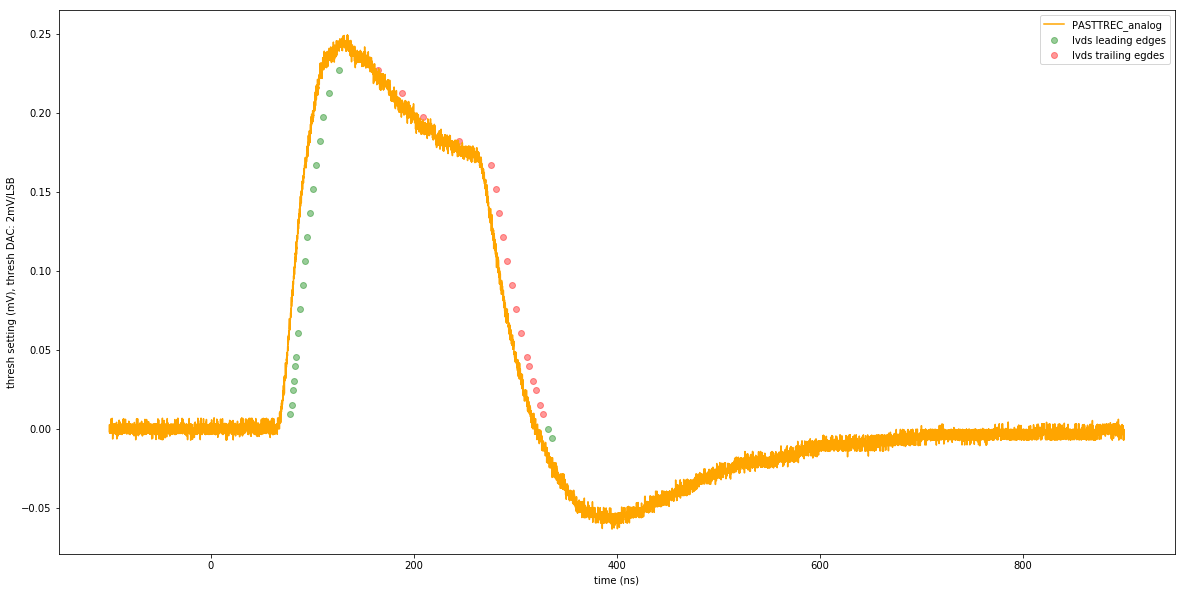

In [6]:
import pasttrec_ctrl as ptc
import time

lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])

channel = 7

n=1



my_baseline = 6


ptc.init_board("0001",1,15,4,127)
#ptc.init_board("0001",1,20,2,127) # alternative setting, pkt 20, gain 2, does the model still hold?
#ptc.init_board("0001",1,10,1,127) # alternative setting
ptc.set_baseline("0001",1,channel,my_baseline) # zero V baseline for my channel relative to thr=0 - > scan said baseline at 5

thresholds = range(0,127,8)
baselines = range(-15,16,8)


meta_stats = {}


c = 0
for i in thresholds:
  ptc.set_threshold("0001",1,0,i) # tdc, conn, chip thresh
  meta_stats[i] = lecroy.measure_statistics(["P3","P4"],n)
  time.sleep(0.1)
  c += 1


ptc.set_threshold("0001",1,0,0) # tdc, conn, chip thresh
for j in baselines:
  ptc.set_baseline("0001",1,channel,j) 
  meta_stats[my_baseline-j] = lecroy.measure_statistics(["P3","P4"],n)
  time.sleep(0.1)
  c += 1



c = 0
my_ysteps = list(meta_stats.keys())
my_ysteps.sort()

scat_y          = np.zeros(len(my_ysteps)*n)
scat_x_leading  = np.zeros(len(my_ysteps)*n)
scat_x_trailing = np.zeros(len(my_ysteps)*n)

for i in my_ysteps:
  for j in range(0,n):
    scat_y[c] = i
    xl = meta_stats[i]["P3"][j]
    xt = meta_stats[i]["P3"][j] + meta_stats[i]["P4"][j]
    scat_x_leading[c] = xl # median filtered
    scat_x_trailing[c] = xt # median filtered
    c+=1


scat_x_leading *= 1e9
scat_x_trailing *= 1e9

scat_y *= 0.001895

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.scatter(scat_x_leading,scat_y  ,label="lvds leading edges", c="g",alpha=0.4)
plt.scatter(scat_x_trailing,scat_y ,label="lvds trailing egdes",c="r",alpha=0.4)
#plt.plot(scx,ana_wav,label="analog waveform")
plt.xlabel("time (ns)")
plt.ylabel("thresh setting (mV), thresh DAC: 2mV/LSB")
plt.legend()
plt.show()
